In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## 71

In [2]:
!cp ./drive/MyDrive/100pon/data/chap08_data.tar.bz2 ./
!tar -jxvf ./chap08_data.tar.bz2

./chap08_data.pickle


In [3]:
import pickle

with open('./chap08_data.pickle', 'rb') as f:
    data = pickle.load(f)

X_train, y_train = torch.from_numpy(data['X_train'].astype(np.float32)), torch.from_numpy(data['y_train'])
X_valid, y_valid = torch.from_numpy(data['X_valid'].astype(np.float32)), torch.from_numpy(data['y_valid'])
X_test, y_test = torch.from_numpy(data['X_test'].astype(np.float32)), torch.from_numpy(data['y_test'])

In [4]:
class MLP(nn.Module):

  def __init__(self, in_dim, out_dim):
    super(MLP, self).__init__()
    self.linear = nn.Linear(in_dim, out_dim)

  def forward(self, x):
    x = self.linear(x)
    return F.softmax(x, dim=1)

In [5]:
model = MLP(in_dim=300, out_dim=4)

In [6]:
print('正解ラベル:', y_train[:4])
print('予測結果:', model.forward(X_train[:4]).argmax(dim=1))

正解ラベル: tensor([0, 2, 0, 2])
予測結果: tensor([0, 0, 0, 1])


## 72

In [7]:
# クロスエントロピー誤差
x = X_train[:4]
y = y_train[:4]
output = model.forward(x)
loss = (torch.eye(output.shape[1])[y] * (- torch.log(output))).sum(axis=1).mean()
print(loss)

tensor(1.3675, grad_fn=<MeanBackward0>)


In [8]:
loss.backward()

In [9]:
# 勾配
for param in model.parameters():
  print(param.grad)

tensor([[ 0.0084,  0.0114, -0.0031,  ..., -0.0357, -0.0039,  0.0138],
        [-0.0030,  0.0106, -0.0011,  ..., -0.0082, -0.0078, -0.0055],
        [-0.0025, -0.0317,  0.0047,  ...,  0.0507,  0.0191, -0.0030],
        [-0.0029,  0.0097, -0.0005,  ..., -0.0069, -0.0074, -0.0053]])
tensor([-0.2375,  0.2520, -0.2490,  0.2346])


## 73-76

参考:
*   https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
*   https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
*   https://dreamer-uma.com/pytorch-dataset/#PyTorchDataset



In [10]:
model = MLP(in_dim=300, out_dim=4)
optimizer = optim.SGD(model.parameters(), lr=0.99)
epochs = 100
save_path = './chap08_checkpoint.pt'

In [11]:
checkpoints = []
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []
for epoch in range(epochs):
  model.train()
  y = model.forward(X_train)
  train_loss = (torch.eye(y.shape[1])[y_train] * (- torch.log(y))).sum(axis=1).mean()

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  train_losses.append(train_loss.detach().numpy())
  train_acc = (y.argmax(dim=1) == y_train).sum() / len(y_train)
  train_accs.append(train_acc.detach().numpy())

  model.eval()
  y = model.forward(X_valid)
  valid_loss = (torch.eye(y.shape[1])[y_valid] * (- torch.log(y))).sum(axis=1).mean()

  valid_losses.append(valid_loss.detach().numpy())
  valid_acc = (y.argmax(dim=1) == y_valid).sum() / len(y_valid)
  valid_accs.append(valid_acc.detach().numpy())

  checkpoints.append({
                    'epoch': epoch,
                    'model_state': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'valid_loss': valid_loss
                    })

  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
  torch.save(checkpoints, save_path)

epoch: 1 Train [loss: 1.3764, accuracy: 0.3409], Valid [loss: 1.2056, accuracy: 0.6762]
epoch: 2 Train [loss: 1.2104, accuracy: 0.6620], Valid [loss: 1.1206, accuracy: 0.7436]
epoch: 3 Train [loss: 1.1284, accuracy: 0.7266], Valid [loss: 1.0677, accuracy: 0.7646]
epoch: 4 Train [loss: 1.0776, accuracy: 0.7463], Valid [loss: 1.0294, accuracy: 0.7721]
epoch: 5 Train [loss: 1.0407, accuracy: 0.7511], Valid [loss: 0.9988, accuracy: 0.7729]
epoch: 6 Train [loss: 1.0112, accuracy: 0.7535], Valid [loss: 0.9731, accuracy: 0.7721]
epoch: 7 Train [loss: 0.9863, accuracy: 0.7552], Valid [loss: 0.9507, accuracy: 0.7729]
epoch: 8 Train [loss: 0.9645, accuracy: 0.7561], Valid [loss: 0.9308, accuracy: 0.7729]
epoch: 9 Train [loss: 0.9451, accuracy: 0.7567], Valid [loss: 0.9129, accuracy: 0.7744]
epoch: 10 Train [loss: 0.9276, accuracy: 0.7578], Valid [loss: 0.8966, accuracy: 0.7759]
epoch: 11 Train [loss: 0.9115, accuracy: 0.7583], Valid [loss: 0.8817, accuracy: 0.7766]
epoch: 12 Train [loss: 0.8968,

In [12]:
model.eval()
y = model.forward(X_train)
train_loss = (torch.eye(y.shape[1])[y_train] * (- torch.log(y))).sum(axis=1).mean()
train_acc = (y.argmax(dim=1) == y_train).sum() / len(y_train)

y = model.forward(X_valid)
valid_loss = (torch.eye(y.shape[1])[y_valid] * (- torch.log(y))).sum(axis=1).mean()
valid_acc = (y.argmax(dim=1) == y_valid).sum() / len(y_valid)

print('Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(train_loss, train_acc, valid_loss, valid_acc))

Train [loss: 0.5514, accuracy: 0.8103], Valid [loss: 0.5392, accuracy: 0.8141]


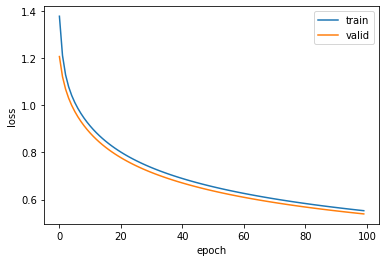

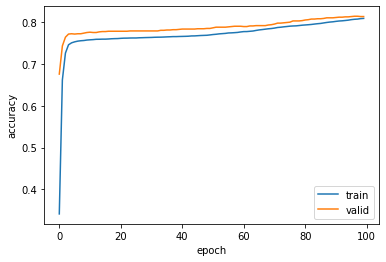

In [13]:
import matplotlib.pyplot as plt

x = np.arange(epochs)
plt.plot(x, train_losses, label='train')
plt.plot(x, valid_losses, label='valid')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

x = np.arange(epochs)
plt.plot(x, train_accs, label='train')
plt.plot(x, valid_accs, label='valid')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [14]:
checkpoint = torch.load(save_path)
print(checkpoint[0])

{'epoch': 0, 'model_state': OrderedDict([('linear.weight', tensor([[-0.2265, -0.0844, -0.0288,  ...,  0.3492,  0.1567, -0.3790],
        [ 0.2421, -0.1007,  0.0327,  ..., -0.0519, -0.0452, -0.1194],
        [ 0.0108,  0.1433, -0.1843,  ..., -0.4667, -0.2883,  0.3811],
        [-0.0177,  0.0218,  0.1488,  ...,  0.1185,  0.2319,  0.1161]])), ('linear.bias', tensor([ 0.3336, -0.2113,  0.2809, -0.4478]))]), 'optimizer_state': {'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}}, 'param_groups': [{'lr': 0.99, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0, 1]}]}, 'train_loss': tensor(1.3764, requires_grad=True), 'valid_loss': tensor(1.2056, requires_grad=True)}


## 77, 78

In [17]:
dataset = {}
dataset['train'] = torch.utils.data.TensorDataset(X_train, y_train)
dataset['valid'] = torch.utils.data.TensorDataset(X_valid, y_valid)
dataset['test'] = torch.utils.data.TensorDataset(X_test, y_test)

In [18]:
import time

In [20]:
epochs = 10
exe_times = {'cpu': [], 'cuda': []}

for dev in ['cpu', 'cuda']:

  device = torch.device(dev)
  
  for pow in range(14):

    batch_size = 2 ** pow
    train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
    train_size = len(train_dataloader.dataset)
    valid_size = len(valid_dataloader.dataset)

    model = MLP(in_dim=300, out_dim=4)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    
    epoch_time = []
    print(f'batch_size: {batch_size} ({dev})')
    for epoch in range(epochs):

      time_start = time.time()
      model.train()
      num_acc = 0
      for x, t in train_dataloader:
        x = x.to(device)
        t_onehot = torch.eye(y.shape[1])[t].to(device)
        y = model.forward(x)
        train_loss = (t_onehot * (- torch.log(y))).sum(axis=1).mean()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        num_acc += (y.argmax(dim=1).cpu() == t).sum()

      train_losses.append(train_loss.cpu().item())
      train_accs.append(num_acc.item() / train_size)

      epoch_time.append(time.time() - time_start)
      
      model.eval()
      num_acc = 0
      for x, t in valid_dataloader:
        x = x.to(device)
        t_onehot = torch.eye(y.shape[1])[t].to(device)
        y = model.forward(x)
        valid_loss = (t_onehot * (- torch.log(y))).sum(axis=1).mean()

        num_acc += (y.argmax(dim=1).cpu() == t).sum()

      valid_losses.append(valid_loss.cpu().item())
      valid_accs.append(num_acc.item() / valid_size)
      
      print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
            format(epoch+1, train_losses[-1], train_accs[-1], 
                  valid_losses[-1], valid_accs[-1]))
    
    exe_times[dev].append(np.mean(epoch_time))
    print('')

batch_size: 1 (cpu)
epoch: 1 Train [loss: 0.0698, accuracy: 0.7727], Valid [loss: 0.2378, accuracy: 0.8231]
epoch: 2 Train [loss: 0.0350, accuracy: 0.8341], Valid [loss: 0.1655, accuracy: 0.8598]
epoch: 3 Train [loss: 0.3994, accuracy: 0.8531], Valid [loss: 0.1219, accuracy: 0.8756]
epoch: 4 Train [loss: 0.0240, accuracy: 0.8624], Valid [loss: 0.1162, accuracy: 0.8838]
epoch: 5 Train [loss: 0.0496, accuracy: 0.8678], Valid [loss: 0.0962, accuracy: 0.8883]
epoch: 6 Train [loss: 0.9921, accuracy: 0.8719], Valid [loss: 0.0777, accuracy: 0.8868]
epoch: 7 Train [loss: 0.0237, accuracy: 0.8770], Valid [loss: 0.0824, accuracy: 0.8928]
epoch: 8 Train [loss: 0.0403, accuracy: 0.8802], Valid [loss: 0.0711, accuracy: 0.8928]
epoch: 9 Train [loss: 0.0332, accuracy: 0.8804], Valid [loss: 0.0754, accuracy: 0.8951]
epoch: 10 Train [loss: 0.1090, accuracy: 0.8824], Valid [loss: 0.0778, accuracy: 0.8966]

batch_size: 2 (cpu)
epoch: 1 Train [loss: 0.3313, accuracy: 0.7519], Valid [loss: 0.6027, accuracy

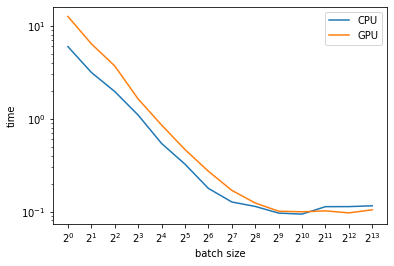

In [21]:
import matplotlib.pyplot as plt

x = [2**pow for pow in range(14)]

plt.plot(x, exe_times['cpu'], label='CPU')
plt.plot(x, exe_times['cuda'], label='GPU')
plt.xscale('log', basex=2)
plt.yscale('log')
plt.xticks(x)
plt.xlabel('batch size')
plt.ylabel('time')
plt.legend()
plt.show()

## 79

In [33]:
class MLP(nn.Module):

  def __init__(self, in_dim, hid1_dim, hid2_dim, out_dim):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(in_dim, hid1_dim)
    self.linear2 = nn.Linear(hid1_dim, hid2_dim)
    self.linear3 = nn.Linear(hid2_dim, out_dim)

    self.bn1 = nn.BatchNorm1d(hid1_dim)
    self.bn2 = nn.BatchNorm1d(hid2_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.bn1(x).relu()
    x = self.linear2(x)
    x = self.bn2(x).relu()
    x = self.linear3(x).relu()
    return F.softmax(x, dim=1)

In [34]:
batch_size = 64
train_dataloader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset['valid'], batch_size=batch_size, shuffle=False)
train_size = len(train_dataloader.dataset)
valid_size = len(valid_dataloader.dataset)

In [35]:
hid1_dim, hid2_dim = 128, 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(in_dim=300, hid1_dim=hid1_dim, hid2_dim=hid2_dim, out_dim=4)
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [36]:
epochs = 100

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(epochs):

  model.train()
  num_acc = 0
  losses = []
  for x, t in train_dataloader:
    x = x.to(device)
    t = t.to(device)
    y = model.forward(x)
    train_loss = loss(y, t)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    losses.append(train_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  train_losses.append(np.mean(losses))
  train_accs.append(num_acc.item() / train_size)

  model.eval()
  num_acc = 0
  losses = []
  for x, t in valid_dataloader:
    x = x.to(device)
    t = t.to(device)
    y = model.forward(x)
    valid_loss = loss(y, t)
    
    losses.append(valid_loss.cpu().item())
    num_acc += (y.argmax(dim=1).cpu() == t.cpu()).sum()

  valid_losses.append(np.mean(losses))
  valid_accs.append(num_acc.item() / valid_size)
  
  print('epoch: {} Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(epoch+1, train_losses[-1], train_accs[-1], 
              valid_losses[-1], valid_accs[-1]))

epoch: 1 Train [loss: 0.9226, accuracy: 0.8534], Valid [loss: 0.8526, accuracy: 0.8966]
epoch: 2 Train [loss: 0.8568, accuracy: 0.8879], Valid [loss: 0.8491, accuracy: 0.8973]
epoch: 3 Train [loss: 0.8455, accuracy: 0.8973], Valid [loss: 0.8514, accuracy: 0.8913]
epoch: 4 Train [loss: 0.8320, accuracy: 0.9119], Valid [loss: 0.8424, accuracy: 0.9025]
epoch: 5 Train [loss: 0.8255, accuracy: 0.9181], Valid [loss: 0.8391, accuracy: 0.9078]
epoch: 6 Train [loss: 0.8186, accuracy: 0.9261], Valid [loss: 0.8412, accuracy: 0.9025]
epoch: 7 Train [loss: 0.8120, accuracy: 0.9321], Valid [loss: 0.8446, accuracy: 0.8981]
epoch: 8 Train [loss: 0.8098, accuracy: 0.9337], Valid [loss: 0.8420, accuracy: 0.9003]
epoch: 9 Train [loss: 0.8046, accuracy: 0.9401], Valid [loss: 0.8375, accuracy: 0.9063]
epoch: 10 Train [loss: 0.7972, accuracy: 0.9473], Valid [loss: 0.8474, accuracy: 0.8943]
epoch: 11 Train [loss: 0.7970, accuracy: 0.9471], Valid [loss: 0.8418, accuracy: 0.9018]
epoch: 12 Train [loss: 0.7958,

In [37]:
model = model.cpu()
model.eval()
y = model.forward(X_train)
train_loss = (torch.eye(y.shape[1])[y_train] * (- torch.log(y))).sum(axis=1).mean()
train_acc = (y.argmax(dim=1) == y_train).sum() / len(y_train)

y = model.forward(X_valid)
valid_loss = (torch.eye(y.shape[1])[y_valid] * (- torch.log(y))).sum(axis=1).mean()
valid_acc = (y.argmax(dim=1) == y_valid).sum() / len(y_valid)

print('Train [loss: {:.4f}, accuracy: {:.4f}], Valid [loss: {:.4f}, accuracy: {:.4f}]'.
        format(train_loss, train_acc, valid_loss, valid_acc))

Train [loss: nan, accuracy: 0.9804], Valid [loss: nan, accuracy: 0.9183]
